In [8]:
!apt install subversion

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!svn checkout -q https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [3]:
import os

root_dir = '/content/Sign-Language-Digits-Dataset/trunk/Dataset'

for dir in sorted(os.listdir(root_dir)):
  print(f'Class {dir}: ', len(os.listdir(os.path.join(root_dir, dir))), 'files')

Class 0:  205 files
Class 1:  206 files
Class 2:  206 files
Class 3:  206 files
Class 4:  207 files
Class 5:  207 files
Class 6:  207 files
Class 7:  206 files
Class 8:  208 files
Class 9:  204 files


In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [5]:
import cv2

img = cv2.imread('/content/Sign-Language-Digits-Dataset/trunk/Dataset/0/IMG_1118.JPG')
img.shape

(100, 100, 3)

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
        './data/Sign-Language-Digits',
        target_size=(100, 100),
        batch_size=32,
        shuffle=True,
        subset="training",
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        './data/Sign-Language-Digits',
        target_size=(100, 100),
        batch_size=32,
        shuffle=False,
        subset="validation",
        class_mode='categorical')

Found 1862 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [4]:
import math
import numpy as np

number_of_examples = len(train_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32))

X_train = []
y_train = []

for i in range(0,int(number_of_generator_calls)):
    X_train.extend(np.array(train_generator[i][0]))
    y_train.extend(np.array(train_generator[i][1]))

X_train = np.array(X_train)
y_train = np.array(y_train)

print('X_train shape : ', X_train.shape)
print('y train shape : ', y_train.shape)

In [3]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.xception = Xception(
                              include_top=False, 
                              weights='imagenet',  
                              input_shape=(100, 100, 3)
                            )
    self.xception.trainable = False
    self.gb = GlobalAveragePooling2D()
    self.fc = Dense(10, activation='softmax')

  def call(self, inputs):
    x = self.xception(inputs)
    x = self.gb(x)
    x = self.fc(x)
    return x

In [4]:
import warnings
warnings.filterwarnings("ignore")

def create_model(lr=1e-3, momentum=0.9):
  model = MyModel()
  model.compile(
                optimizer=SGD(lr=lr, momentum=momentum),
                loss='categorical_crossentropy', metrics=['accuracy']
                )
  return model
model = create_model()

model.build((None,100,100,3))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


In [16]:
learning_rates= [1e-2, 3e-3, 1e-4, 3e-5, 1e-6]
momentums = [0.1, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(lr=learning_rates, momentum=momentums)

model = KerasClassifier(build_fn=create_model, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [17]:
warnings.filterwarnings("ignore")
grid_result = grid.fit(X_train, y_train)

In [18]:
print('best params : ', str(grid_result.best_params_))
print('best score  : ', grid_result.best_score_)

best params :  {'lr': 0.01, 'momentum': 0.9}
best score  :  0.5241545836130778


In [24]:
model = create_model(**grid_result.best_params_)

In [25]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(
                    'SLDD',
                    monitor='val_accuracy',
                    verbose=0,
                    save_weights_only=True,
                    save_best_only=True
                    )
            ]

history = model.fit(
                     train_generator,
                     epochs = 100,
                     callbacks = callbacks,
                     validation_data = validation_generator,
                     verbose = 1
                   )

Epoch 1/100
59/59 [==============================] - 10s 164ms/step - loss: 1.5474 - accuracy: 0.4474 - val_loss: 1.8197 - val_accuracy: 0.3100
Epoch 2/100
59/59 [==============================] - 9s 153ms/step - loss: 1.1474 - accuracy: 0.5999 - val_loss: 1.8605 - val_accuracy: 0.3950
Epoch 3/100
59/59 [==============================] - 9s 153ms/step - loss: 0.9882 - accuracy: 0.6745 - val_loss: 1.6362 - val_accuracy: 0.4000
Epoch 4/100
59/59 [==============================] - 9s 153ms/step - loss: 0.9628 - accuracy: 0.6531 - val_loss: 1.7485 - val_accuracy: 0.4050
Epoch 5/100
59/59 [==============================] - 9s 149ms/step - loss: 0.8717 - accuracy: 0.7019 - val_loss: 1.6770 - val_accuracy: 0.3950
Epoch 6/100
59/59 [==============================] - 9s 151ms/step - loss: 0.7965 - accuracy: 0.7315 - val_loss: 1.5601 - val_accuracy: 0.4550
Epoch 7/100
59/59 [==============================] - 9s 148ms/step - loss: 0.7697 - accuracy: 0.7406 - val_loss: 1.5037 - val_accuracy: 0.445

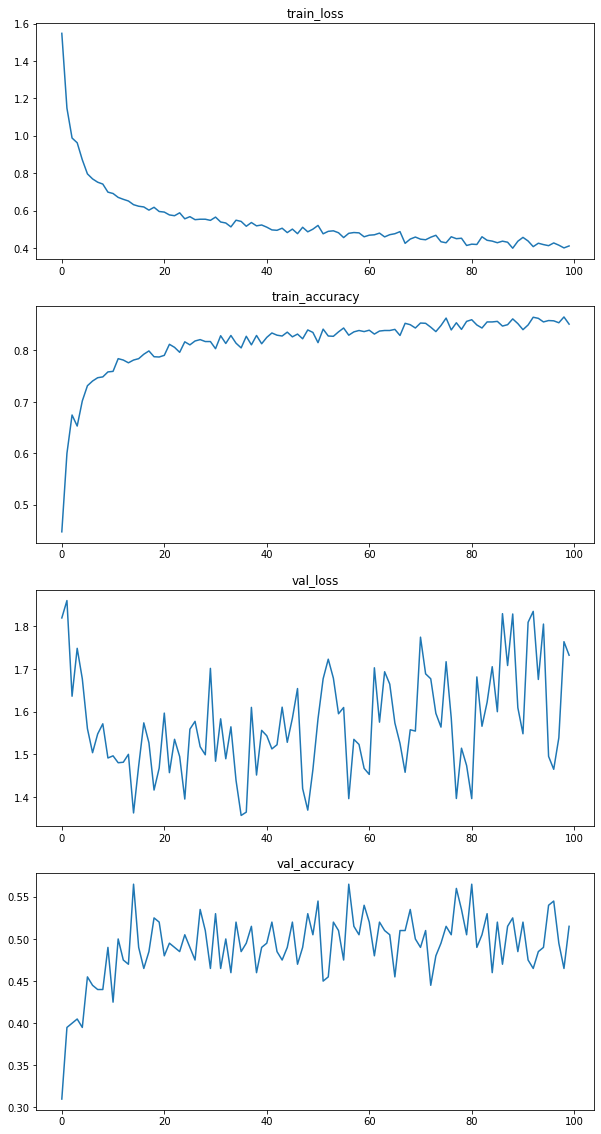

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))

plt.subplot(4,1,1)
plt.plot(history.history['loss'])
plt.title('train_loss');

plt.subplot(4,1,2)
plt.plot(history.history['accuracy'])
plt.title('train_accuracy');

plt.subplot(4,1,3)
plt.plot(history.history['val_loss'])
plt.title('val_loss');

plt.subplot(4,1,4)
plt.plot(history.history['val_accuracy'])
plt.title('val_accuracy');

In [12]:
model.load_weights(r'C:\Users\bank\Desktop\Tensorflow Cetificated\checkpoints\Sign-Language-Digits\SLDD')
loss, acc = model.evaluate(train_generator, verbose=2)
print("model, accuracy: {:5.2f}%".format(100*acc))

59/59 - 25s - loss: 0.4560 - accuracy: 0.8437
model, accuracy: 84.37%
